# Calculate the monthly Sun position

### Study Ecliptic for path of Sun
Create a DataFrame with monthly info from the livetime cubes, adding solar positions for the start of each month. Save the result as a csv file

In [1]:
%matplotlib inline
import pyfits, glob, pickle
from skymaps import SolarSystem, JulianDate, SkyDir

In [2]:
#check mission times for the months; extract TSTART and TSTOP from the livetime cubes
lc=sorted(glob.glob(os.path.expandvars('$FERMI/data/P8_P301/Source/ltcube_*_zmax100.fits'))); 
print 'Livetime cubes for %d months found' % len(lc)

Livetime cubes for 73 months found


In [3]:
month_dict = dict()
for i in range(len(lc)):
    h = pyfits.open(lc[i])[0].header; 
    month_dict[i]=dict( tstart=h['TSTART'], tstop=h['TSTOP'],  filename=lc[i].split('/')[-1])

In [4]:
monthdf=pd.DataFrame(month_dict).T #, columns=range(1,len(lc))).T
monthdf.index=range(1,len(lc)+1)
monthdf.index.name='month'

In [5]:
ss=SolarSystem()
spd = JulianDate.secondsPerDay
jdmission = JulianDate.missionStart().seconds()/spd
zaxis = SkyDir(270,90-23.439281) #NP in Ecliptic

tss=[]; sun_ra=[]; sun_dec=[]
for t in monthdf.tstart:
    sun_start_dir = ss.direction(JulianDate((t/spd+jdmission)))
    sun_ra.append(sun_start_dir.ra()); sun_dec.append(sun_start_dir.dec())
    sdstart = sun_start_dir.zenithCoords(zaxis);
    assert abs(sdstart[1])<0.01, 'bad ecliptic? %s' %sdstart
    tss.append(sdstart[0])

In [6]:
monthdf['sun_ra']  = np.asarray(sun_ra, np.float32)
monthdf['sun_dec'] = np.asarray(sun_dec, np.float32)
monthdf['sun_elon'] = np.array(tss, np.float32)
monthdf.to_csv(os.path.expandvars('$FERMI/skymodels/P301_monthly/month_info.csv'))

## Make table of ecliptic coordinates

In [7]:
from skymaps import Band
band = Band(512)
npix = 12* 512**2
%time ecliptic = np.array([np.array(band.dir(i).zenithCoords(zaxis),np.float32) for i in range(npix)])

CPU times: user 22.4 s, sys: 2.66 s, total: 25 s
Wall time: 25.1 s


### Make plots to test

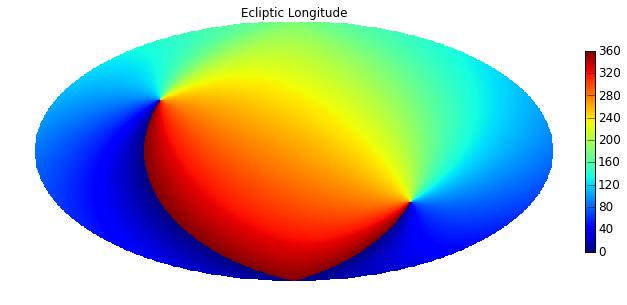

In [8]:
from uw.like2.pub import healpix_map; reload(healpix_map);
eclon = healpix_map.HParray( 'eclon', ecliptic[:,0],)
eclon.plot(title='Ecliptic Longitude');

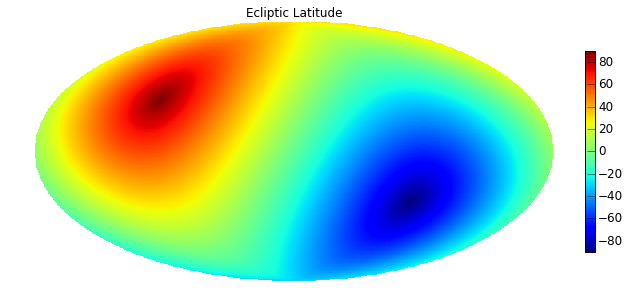

In [9]:
eclat = healpix_map.HParray( 'eclat', ecliptic[:,1],)
eclat.plot(title='Ecliptic Latitude');

###Save the table to a file

In [10]:
import pickle
pickle.dump(ecliptic, open(os.path.expandvars('$FERMI/misc/ecliptic_512.pickle'), 'w'))

In [11]:
%time x= pickle.load(open(os.path.expandvars('$FERMI/misc/ecliptic_512.pickle')))

CPU times: user 455 ms, sys: 16 ms, total: 471 ms
Wall time: 503 ms


So, is this worth it? 20 s to create a table, only in an initialization phase, vs. 0.5 s to load a file.